# Import dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/dcase-aml")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dcase-aml


In [2]:
import os
import pandas as pd

notebook_executed_in="kaggle" # or colab

if notebook_executed_in == "kaggle":
    train_dir = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train'
elif notebook_executed_in == "colab":
    train_dir = 'dcase-aml/dev_data/_dev_data/slider/train'  # TODO: verify path in Colab
else:
    raise ValueError(f"Unsupported notebook: {notebook_executed_in}")

    
# List all files in the train directory
file_names = os.listdir(train_dir)

# Optional: filter to include only certain file types (e.g., .wav, .csv, etc.)
# file_names = [f for f in file_names if f.endswith('.wav')]

# Create a DataFrame
df = pd.DataFrame(file_names, columns=['filename'])

# Display the DataFrame
df.head()

,filename
0,normal_id_02_00000546.wav
1,normal_id_02_00000764.wav
2,normal_id_00_00000530.wav
3,normal_id_02_00000820.wav
4,normal_id_02_00000102.wav


## Preprocessing : build melspectrograms from audio files

- Input : audio files in data/data
- Output : melspectrograms of size

In [3]:
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm

## Choose the paths

In [4]:
# Enter the path to audio data
PATH_DATASET = "/kaggle/working/"
# Enter the path where spectrograms will be saved
PATH_FEATURES = PATH_DATASET+'Features/'
PATH_MELSPEC = PATH_FEATURES + 'melspec_313_128/'

## Function to build the dataframe of file names with their features for each machine type

In [5]:
#Get list of files in train and test directory
def get_df_files(machine_str):

    path_train_folder = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train'
    path_test_folder = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/test'
    
    if not os.path.exists(path_train_folder):
        os.makedirs(path_train_folder)
        
    if not os.path.exists(path_test_folder):
        os.makedirs(path_test_folder)


    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted = filename.replace('.wav', '').split('_')
        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "/" + filename,
            'filename': filename,
            'status': splitted[0],            # normal / anomaly
            'machine_id': splitted[1] + '_' + splitted[2],  # id_00
            'file_index': splitted[3]         # progressivo
        })

    #Loop through filenames
    for filename in test_files:

         #Get filename as list of string
        splitted = filename.replace('.wav', '').split('_')
        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder + "/" + filename,
            'filename': filename,
            'status': splitted[0],            # normal / anomaly
            'machine_id': splitted[1] + '_' + splitted[2],  # id_00
            'file_index': splitted[3]         # progressivo
        })

    #Get file dataframe
    df_files = pd.DataFrame(list_dict_file)
    
    return df_files

## Functions to compute and save the spectograms

In [6]:
def build_melspectrogram(audio_name, spectro_params):
    #Get audio array
    audio_array, sr = librosa.load(audio_name, sr=None)

    #Get mel spectogram
    melspectrogram = librosa.feature.melspectrogram(
        y = audio_array, 
        n_fft = spectro_params['n_fft'], 
        hop_length = spectro_params['hop_length'], 
        n_mels = spectro_params['n_mels']
    )
    # Express in decibel units
    melspectrogram = librosa.power_to_db(melspectrogram, ref=1e-12)   #  ref=np.max 
    # Flatten the spectrogram
    #print("Initial Spectro shape = ", melspectrogram.shape)
    melspectrogram = melspectrogram.reshape(1, -1)
    #print("Final Spectro shape = ", melspectrogram.shape)
    
    return melspectrogram

def compute_and_save_spectros(machine_str, spectro_params):
    # Check or create folders
    if not os.path.exists(PATH_FEATURES):
        os.makedirs(PATH_FEATURES)

    if not os.path.exists(PATH_MELSPEC):
        os.makedirs(PATH_MELSPEC)

    path_machine_folder = PATH_MELSPEC + machine_str + '/'
    if not os.path.exists(path_machine_folder):
        os.makedirs(path_machine_folder)
        
    # Get the dataframe of files for this machine
    df = get_df_files(machine_str)
    
    # Loop through the dataframe
    for idx, row in df.iterrows():
        # Get audio array
        audio_path = row['filepath']
        # Build the spectrogram
        melspectrogram = build_melspectrogram(audio_path, spectro_params)   
        # Save 
        filename = path_machine_folder + row['filename'].split('.wav')[0]
        np.save(filename, melspectrogram)

## Run it for all machine types

In [7]:
spectro_params = dict(
    n_fft = 1024,     # length of the FFT window
    hop_length = 512,    # number of samples between successive frames
    n_mels = 128       # number of Mel bands to generate
)

machines_list = ['slider']

for machine in tqdm(machines_list):
    compute_and_save_spectros(machine, spectro_params)

100%|██████████| 1/1 [01:33<00:00, 93.21s/it]


### Test

In [8]:
audio_name = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train/normal_id_00_00000000.wav'

spectro_params = dict(
    n_fft = 1024, 
    hop_length = 512, 
    n_mels=128
)

spectro = build_melspectrogram(audio_name, spectro_params)

## Plot one spectrogram for test

In [9]:
def plot_spectro(filepath):
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Plot the spectrogram
    librosa.display.specshow(spectro_array, sr = 16000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')

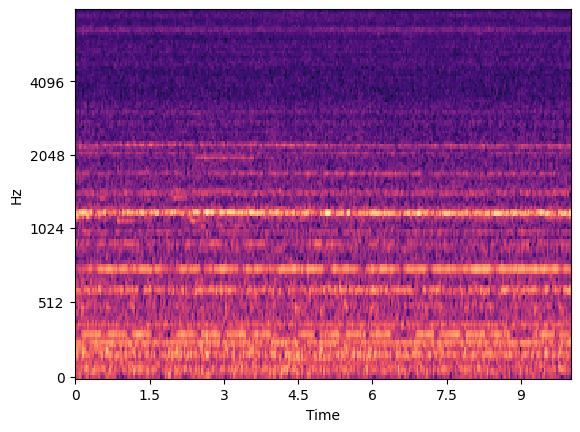

In [12]:
path = '/kaggle/working/Features/melspec_313_128/slider/normal_id_00_00000010.npy'
plot_spectro(path)

## Normalization

In [13]:
import os
import numpy as np

def load_all_spectrograms(folder):
    data = []
    for file in os.listdir(folder):
        if file.endswith(".npy") and "normal" in file:
            array = np.load(os.path.join(folder, file)).reshape(-1)  # Flatten per rete fully-connected
            data.append(array)
    return np.array(data)

# Sostituisci con il tuo percorso corretto
folder_path = "/kaggle/working/Features/melspec_313_128/slider"
X_train = load_all_spectrograms(folder_path)

print("Shape del dataset:", X_train.shape)

Shape del dataset: (2370, 40064)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Training Autoencoder

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Architettura Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Dati e dataloader
tensor_data = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Istanza modello
input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(30):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        output = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 1.0934
Epoch 2, Loss: 0.7992
Epoch 3, Loss: 0.6900
Epoch 4, Loss: 0.6484
Epoch 5, Loss: 0.6191
Epoch 6, Loss: 0.5952
Epoch 7, Loss: 0.5761
Epoch 8, Loss: 0.5604
Epoch 9, Loss: 0.5560
Epoch 10, Loss: 0.5994
Epoch 11, Loss: 0.5580
Epoch 12, Loss: 0.5642
Epoch 13, Loss: 0.5391
Epoch 14, Loss: 0.5248
Epoch 15, Loss: 0.5206
Epoch 16, Loss: 0.5214
Epoch 17, Loss: 0.5092
Epoch 18, Loss: 0.5017
Epoch 19, Loss: 0.4983
Epoch 20, Loss: 0.5019
Epoch 21, Loss: 0.4890
Epoch 22, Loss: 0.4846
Epoch 23, Loss: 0.4827
Epoch 24, Loss: 0.4787
Epoch 25, Loss: 0.4761
Epoch 26, Loss: 0.4824
Epoch 27, Loss: 0.4845
Epoch 28, Loss: 0.4818
Epoch 29, Loss: 0.4828
Epoch 30, Loss: 0.4815


## Anomaly Score Calculation

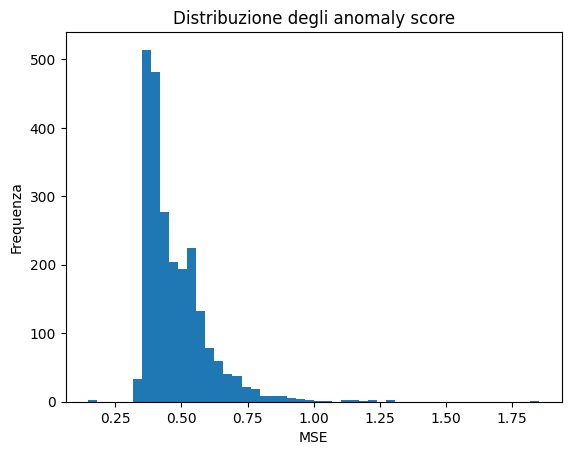

In [16]:
def anomaly_score(model, data):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data, dtype=torch.float32)
        outputs = model(inputs)
        mse = torch.mean((outputs - inputs)**2, dim=1)
    return mse.numpy()

scores = anomaly_score(model, X_train_scaled)

# Visualizza distribuzione dei punteggi
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.title("Distribuzione degli anomaly score")
plt.xlabel("MSE")
plt.ylabel("Frequenza")
plt.show()

## Inference

In [21]:
# 1. Carica SOLO i file anomaly per il test
def load_anomaly_test_data(folder_path, scaler):
    test_data = []
    file_paths = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.npy') and 'anomaly' in fname:
            full_path = os.path.join(folder_path, fname)
            data = np.load(full_path).reshape(-1)  # Flatten
            test_data.append(data)
            file_paths.append(full_path)
    test_data = np.array(test_data)
    test_scaled = scaler.transform(test_data)
    return test_scaled, file_paths

# 2. Percorso della cartella di test (modifica se necessario)
test_folder = "/kaggle/working/Features/melspec_313_128/slider/"  # ← usa il tuo path reale
X_anomaly_scaled, anomaly_file_paths = load_anomaly_test_data(test_folder, scaler)

# 3. Calcola gli anomaly score
anomaly_scores = anomaly_score(model, X_anomaly_scaled)

# 4. Mostra primi risultati
for path, score in zip(anomaly_file_paths[:10], anomaly_scores[:10]):
    print(f"{os.path.basename(path)} → anomaly score: {score:.4f}")

anomaly_id_04_00000167.npy → anomaly score: 0.7740
anomaly_id_04_00000064.npy → anomaly score: 0.8426
anomaly_id_00_00000121.npy → anomaly score: 0.7759
anomaly_id_04_00000118.npy → anomaly score: 0.6042
anomaly_id_00_00000029.npy → anomaly score: 0.6650
anomaly_id_02_00000208.npy → anomaly score: 0.4372
anomaly_id_02_00000188.npy → anomaly score: 0.7668
anomaly_id_00_00000019.npy → anomaly score: 0.7279
anomaly_id_02_00000117.npy → anomaly score: 0.4197
anomaly_id_04_00000062.npy → anomaly score: 0.8224
